<a href="https://colab.research.google.com/github/TheBlackRus/liveproject_HumanPoseEstimation/blob/master/liveproject_humanpose_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download the COCO dataset.

In [2]:
# This code downloads the coco dataset from Amazon S3 in parallel.
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import multiprocessing
import subprocess
files = ['val2017.zip', 'annotations_trainval2017.zip']#, 'train2017.zip']

s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
def download_and_unzip_from_s3(file_name, bucket_name='fast-ai-coco'):
    print("Downloading", file_name)
    s3.download_file(bucket_name, file_name, file_name)
    print("Finished downloading", file_name, ". Starting to unzip.")
    subprocess.run(["unzip", file_name])
    print("Finished unzipping", file_name)

# Download in parallel
num_cpus = multiprocessing.cpu_count()
with multiprocessing.Pool(num_cpus) as p:
    p.map(download_and_unzip_from_s3, files)

print("Done transferring all datasets")

Finished downloading annotations_trainval2017.zip . Starting to unzip.
Finished downloading val2017.zip . Starting to unzip.
Finished unzipping annotations_trainval2017.zip
Finished unzipping val2017.zip
Done transferring all datasets


Generate the input images. 

In [0]:
# read the meta data of the validation set
import json
file_name = "annotations//person_keypoints_val2017.json"
with open(file_name, 'r') as json_raw:
    meta = json.load(json_raw)
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from scipy.io import loadmat
from matplotlib.pyplot import imshow

In [0]:
import json
from torch.utils.data import Dataset
import numpy as np
%matplotlib inline
#from matplotlib.pyplot import imshow
from matplotlib import image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from scipy.ndimage import gaussian_filter

class HumanPoseDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, meta_path, transform=None):
        
        self.meta = self.load_meta(meta_path)
        
        self.img_annotations = self.filter_annotations(self.meta["annotations"])
        #self.img_info = meta["images"]
        #self.img_catogory = meta["categories"][0]["keypoints"]
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]

    def load_meta(self,path):
      
      with open(path, 'r') as json_raw:
          meta = json.load(json_raw)
      return meta

    def filter_annotations(self,meta):
      width = 48 #192 # 12
      height = 64 # 256 # 16
      print("LEN before filter",len(meta))
      annot = filter(lambda x: x["iscrowd"] == 0 and 
                     x['bbox'][2]>= width and x['bbox'][3]>=height and
                     any(map(lambda y: y>0, x["keypoints"][2:-1:3])),
                     meta)
      annot = list(annot)
      print("AFTER", len(annot))
      return annot

    def __len__(self):
        return len(self.img_annotations)

    def get_image_name(self,annot):
      
      img_file = str(annot["image_id"])
      img_file = img_file.zfill(12) +".jpg" #img_info["file_name"]
      return "val2017//"+img_file

    def resize_image(self,img, target_width=192, target_height=256):
      img_resized = cv2.resize(img,(target_width,target_height))
      
      return img_resized

    def crop_image(self,img, upper_left_corner, size):
      start_x, start_y = upper_left_corner
      w,h = size
      img_cropped = img[int(start_y):(int(start_y+h)),int(start_x):int(start_x+w),:]
      return img_cropped

    def adjust_keypoint(self,keypoint, start, scale):
      keypoint_x, keypoint_y= keypoint
      start_x,start_y = start
      sx,sy = scale
      x = (keypoint_x-start_x)*sx
      y = (keypoint_y-start_y)*sy
      return x,y

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        annot = self.img_annotations[idx]
        keypoints = annot["keypoints"]

        img_name = self.get_image_name(annot)
        image = io.imread(img_name)

        target_width = 192
        target_height = 256

        start_x,start_y, w,h = annot["bbox"]
        img_crop = self.crop_image(image, (start_x,start_y),(w,h))
        img_crop = self.resize_image(img_crop,target_width,target_height)
        img = img_crop / 255.0
        img = (img-self.mean)/self.std
        # imgshape (256, 192, 3)
        print("img",img.shape)
        img = img.permute([2,0,1]) # channel first

        #img_batch = torch.Tensor([img, img])
        #print(img_batch.shape)
        #img_batch = img_batch.permute([0,3,2,1])

        sx = target_width/w 
        sy = target_height/h

        validity = annot["keypoints"][2::3]

        validity = np.array(validity)
        validity = validity > 0
        validity = validity.astype(np.int)
        print(validity.shape)

        heatmaps = np.zeros((17,64,48))

        keypoints_adjusted = []
        for i in range(len(keypoints)//3):
          keypoint = (keypoints[i*3],keypoints[i*3+1])
          visible = keypoints[i*3+2]
          
          if visible:
            x,y = self.adjust_keypoint(keypoint,(start_x,start_y),(sx,sy))
            heatmaps[i,int(y/4),int(x/4)] = 1
            heatmaps[i,:,:] =  gaussian_filter(heatmaps[i,:,:], sigma=2)
            print(heatmaps[i,:,:].min(),heatmaps[i,:,:].max())
            heatmaps[i,:,:] -= heatmaps[i,:,:].min() 
            heatmaps[i,:,:] /= heatmaps[i,:,:].max()
            print("N",heatmaps[i,:,:].min(),heatmaps[i,:,:].max())
            plt.matshow(heatmaps[i,:,:])
            print(meta["categories"][0]["keypoints"][i])
          else:
            x,y = (-1,-1)
          keypoints_adjusted.append(x)
          keypoints_adjusted.append(y)
          
        """
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)
        """
        return image, heatmaps, validity

In [52]:
data_val = HumanPoseDataset(meta_path="annotations//person_keypoints_val2017.json")

LEN before filter 11004
AFTER 4795


img (256, 192, 3)
(17,)
0.0 0.039790135140764016
N 0.0 1.0
left_shoulder
0.0 0.039790135140764016
N 0.0 1.0
right_shoulder
0.0 0.039790135140764016
N 0.0 1.0
left_elbow
0.0 0.039790135140764016
N 0.0 1.0
right_elbow
0.0 0.039790135140764016
N 0.0 1.0
left_wrist
0.0 0.039790135140764016
N 0.0 1.0
right_wrist
0.0 0.04153839166731017
N 0.0 1.0
left_hip
0.0 0.039790135140764016
N 0.0 1.0
right_hip
0.0 0.039790135140764016
N 0.0 1.0
right_knee
0.0 0.039790135140764016
N 0.0 1.0
right_ankle


(array([[[ 97,  69,  30],
         [ 99,  65,  19],
         [ 98,  67,  20],
         ...,
         [108,  90,  76],
         [ 82,  64,  64],
         [ 64,  52,  36]],
 
        [[ 99,  67,  20],
         [100,  60,  24],
         [102,  68,  33],
         ...,
         [111,  93,  79],
         [ 82,  65,  58],
         [ 59,  48,  44]],
 
        [[ 96,  67,  25],
         [100,  66,  28],
         [103,  71,  32],
         ...,
         [102,  87,  66],
         [ 83,  70,  54],
         [ 68,  54,  54]],
 
        ...,
 
        [[ 74,  41,  26],
         [ 73,  38,  16],
         [ 71,  40,  12],
         ...,
         [ 77,  56,  29],
         [ 80,  57,  43],
         [ 79,  52,  22]],
 
        [[ 67,  38,  32],
         [ 69,  40,  26],
         [ 66,  37,  19],
         ...,
         [ 83,  56,  26],
         [ 86,  61,  31],
         [ 88,  59,  25]],
 
        [[ 70,  36,  26],
         [ 79,  46,  31],
         [ 71,  43,  22],
         ...,
         [ 91,  59,  34],
  

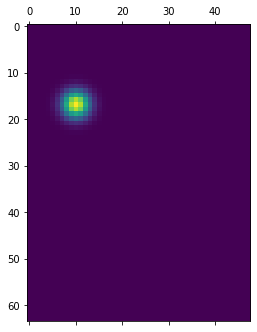

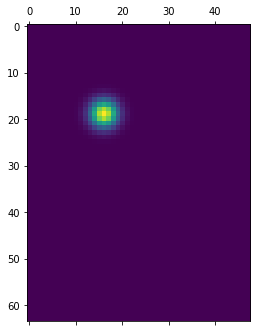

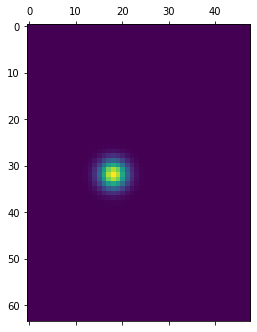

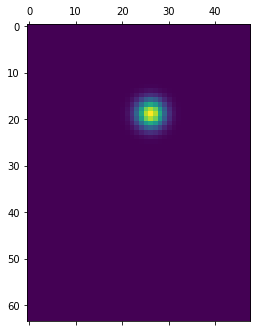

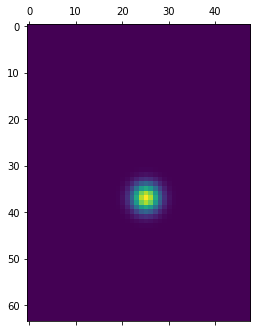

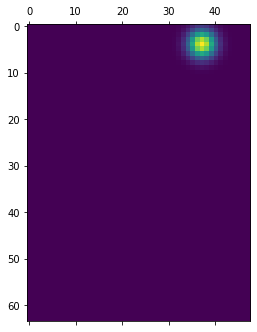

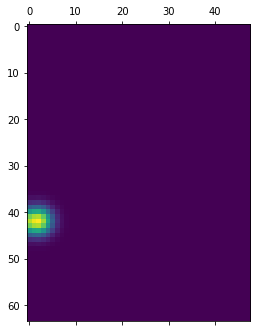

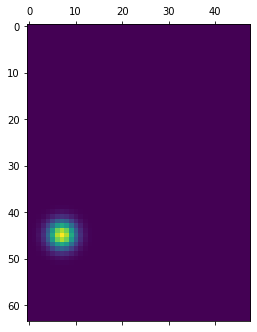

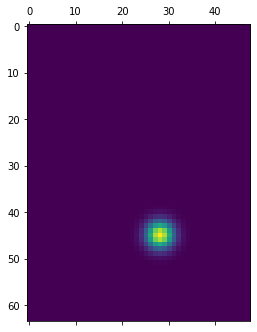

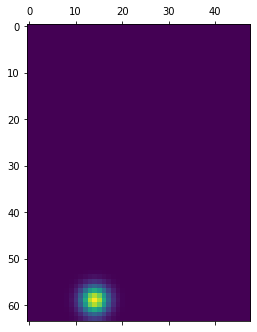

In [53]:
data_val[0]

In [0]:
meta.keys()
print(meta["categories"])

[{'supercategory': 'person', 'id': 1, 'name': 'person', 'keypoints': ['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle'], 'skeleton': [[16, 14], [14, 12], [17, 15], [15, 13], [12, 13], [6, 12], [7, 13], [6, 7], [6, 8], [7, 9], [8, 10], [9, 11], [2, 3], [1, 2], [1, 3], [2, 4], [3, 5], [4, 6], [5, 7]]}]


In [0]:
example = 0
img_info = meta["images"][example]
img_annotation = meta["annotations"][example]
img_catogory = meta["categories"][0]["keypoints"]

In [0]:
x = list(haha)

In [0]:
x[1]["keypoints"][2:-1:3]

[2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0]

In [0]:
import torch.nn as nn
import torch.nn.functional as F

In [89]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #block
        self.conv_1 = nn.Conv2d(in_channels = 3, out_channels=64,kernel_size=7,stride=2,padding=3)
        #nn.init.normal_(self.conv_1.weight, std=0.001)
        #nn.init.constant_(self.conv_1.bias,0)
        self.batch_norm_1 = nn.BatchNorm2d(64) # same as out_channels before layer 
        self.relu_1 = nn.ReLU()
        self.pool_1 = nn.MaxPool2d(2, 2)


        self.conv_2 = nn.Conv2d(in_channels = 64, out_channels=128,kernel_size=5,stride=1,padding=2)
        #nn.init.normal_(self.conv_2.weight, std=0.001)
        #nn.init.constant_(self.conv_2.bias,0)
        self.batch_norm_2 = nn.BatchNorm2d(128) # same as out_channels before layer 
        self.relu_2 = nn.ReLU()
        self.pool_2 = nn.MaxPool2d(2, 2)

        self.conv_3 = nn.Conv2d(in_channels= 128, out_channels=256,kernel_size=5,stride=1,padding=2)
        #nn.init.normal_(self.conv_3.weight, std=0.001)
        #nn.init.constant_(self.conv_3.bias,0)
        self.batch_norm_3 = nn.BatchNorm2d(256) # same as out_channels before layer 
        self.relu_3 = nn.ReLU()
        self.pool_3 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Conv2d(in_channels= 256, out_channels=17,kernel_size=1,stride=1,padding=0) #nn.Linear(24 * 4 * 4, 10)# 24 chans x 32//(2*2*2)
        #nn.init.normal_(self.fc1.weight, std=0.001)
        #nn.init.constant_(self.fc1.bias,0)

    def forward(self, x):
        x = self.conv_1(x)
        x = self.batch_norm_1(x)
        x = self.relu_1(x)
        x = self.pool_1(x)

        x = self.conv_2(x)
        x = self.batch_norm_2(x)
        x = self.relu_2(x)
        x = self.pool_2(x)

        x = self.conv_3(x)
        x = self.batch_norm_3(x)
        x = self.relu_3(x)
        x = self.pool_3(x)

        x = self.fc1(x)#x.view(-1, 24 * 4 * 4)
        #x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #x = self.fc1(x)
        return x



net = Net()
print(net)

Net(
  (conv_1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_1): ReLU()
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch_norm_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch_norm_3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_3): ReLU()
  (pool_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Conv2d(256, 17, kernel_size=(1, 1), stride=(1, 1))
)


In [90]:
from torchsummary import summary
summary(net, (3, 256, 192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 128, 96]           9,472
       BatchNorm2d-2          [-1, 64, 128, 96]             128
              ReLU-3          [-1, 64, 128, 96]               0
         MaxPool2d-4           [-1, 64, 64, 48]               0
            Conv2d-5          [-1, 128, 64, 48]         204,928
       BatchNorm2d-6          [-1, 128, 64, 48]             256
              ReLU-7          [-1, 128, 64, 48]               0
         MaxPool2d-8          [-1, 128, 32, 24]               0
            Conv2d-9          [-1, 256, 32, 24]         819,456
      BatchNorm2d-10          [-1, 256, 32, 24]             512
             ReLU-11          [-1, 256, 32, 24]               0
        MaxPool2d-12          [-1, 256, 16, 12]               0
           Conv2d-13           [-1, 17, 16, 12]           4,369
Total params: 1,039,121
Trainable param